In [31]:

import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
# import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [32]:
scaler = MinMaxScaler()

root_directory = './dataset'

patch_size = 256

In [33]:
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                


Now patchifying image: ./dataset\train\images/120_image_26.png
Now patchifying image: ./dataset\train\images/120_image_32.png
Now patchifying image: ./dataset\train\images/120_image_69.png
Now patchifying image: ./dataset\train\images/120_image_77.png
Now patchifying image: ./dataset\train\images/120_image_82.png
Now patchifying image: ./dataset\train\images/120_image_9.png
Now patchifying image: ./dataset\train\images/165_image_70.png
Now patchifying image: ./dataset\train\images/165_image_91.png
Now patchifying image: ./dataset\train\images/210_image_25.png
Now patchifying image: ./dataset\train\images/45_image_28.png
Now patchifying image: ./dataset\train\images/60_image_14.png
Now patchifying image: ./dataset\train\images/60_image_6.png
Now patchifying image: ./dataset\train\images/60_image_75.png
Now patchifying image: ./dataset\train\images/60_image_87.png
Now patchifying image: ./dataset\train\images/both_image_2.png.png
Now patchifying image: ./dataset\train\images/both_image_3

confirmation of size of patch size

In [34]:
image_dataset[0].shape

(256, 256, 3)

In [35]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask) 
                mask = np.where(mask <= 1, 0, 255)            
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 


Now patchifying mask: ./dataset\train\masks/120_image_26.png
Now patchifying mask: ./dataset\train\masks/120_image_32.png
Now patchifying mask: ./dataset\train\masks/120_image_69.png
Now patchifying mask: ./dataset\train\masks/120_image_77.png
Now patchifying mask: ./dataset\train\masks/120_image_82.png
Now patchifying mask: ./dataset\train\masks/120_image_9.png
Now patchifying mask: ./dataset\train\masks/165_image_70.png
Now patchifying mask: ./dataset\train\masks/165_image_91.png
Now patchifying mask: ./dataset\train\masks/210_image_25.png
Now patchifying mask: ./dataset\train\masks/45_image_28.png
Now patchifying mask: ./dataset\train\masks/60_image_14.png
Now patchifying mask: ./dataset\train\masks/60_image_6.png
Now patchifying mask: ./dataset\train\masks/60_image_75.png
Now patchifying mask: ./dataset\train\masks/60_image_87.png
Now patchifying mask: ./dataset\train\masks/both_image_2.png.png
Now patchifying mask: ./dataset\train\masks/both_image_38.png.png
Now patchifying mask: 

In [36]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

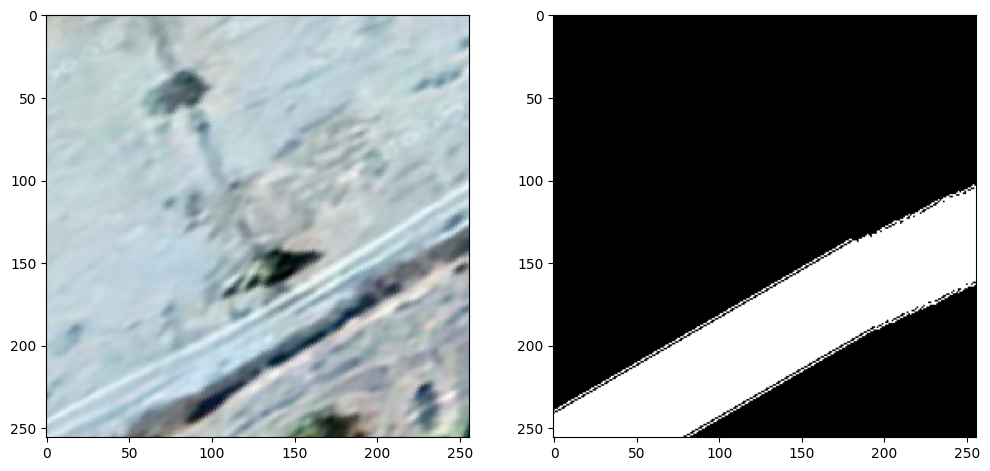

In [37]:
import random
image_number = random.randint(0, len(image_dataset))
image_number = 3
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

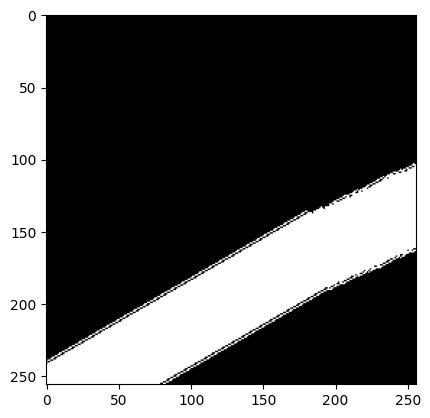

{(0, 0, 0), (255, 255, 255)}


In [38]:

# mask_dataset[0].shape
plt.imshow(mask_dataset[3])
plt.show()
d = set()

# Assuming mask_dataset is a tuple containing two NumPy arrays
for i in range(mask_dataset[3].shape[0]):
    for j in range(mask_dataset[3].shape[1]):
        d.add(tuple(mask_dataset[3][i][j]))

print(d)

In [46]:
def to_int_value(label):
    White = 255
    Black = 0
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg[np.all(label == Black,axis=-1)] = 0
    label_seg[np.all(label == White,axis=-1)] = 1

    label_seg = label_seg[:, :, 0]
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = to_int_value(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [47]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


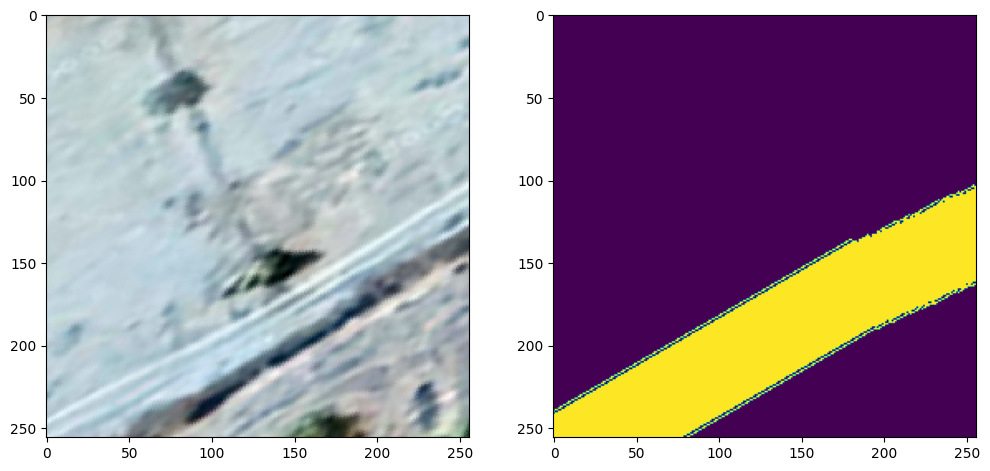

In [48]:
image_number = random.randint(0, len(image_dataset))
image_number = 3
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [49]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [53]:
labels_cat.shape

(2432, 256, 256, 2)

Slip data into training and testing sets

In [55]:
x_train, y_train = image_dataset, labels_cat

In [60]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

Segmentation Models: using `tf.keras` framework.


In [62]:
IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

In [63]:
from model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

In [64]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()

In [66]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,122 (7.40 MB)

 Trainable params: 1,941,122 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
x_test = image_dataset[np.random.choice(len(image_dataset), size=200, replace=False)]
y_test = labels_cat[np.random.choice(len(labels_cat), size=200, replace=False)]

In [71]:
history1 = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(x_train, y_test), 
                    shuffle=False)

MemoryError: Unable to allocate 1.78 GiB for an array with shape (2432, 256, 256, 3) and data type float32